In [1]:
import numpy as np
import cv2
from os import listdir
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
#from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import regularizers
import matplotlib.pyplot as plt
import pathlib

%matplotlib inline

In [2]:
image_gen = ImageDataGenerator(
    rescale = 1/255
)

In [3]:
# Define input directory
input_folder = pathlib.Path("split_data/")

In [4]:
batch_size = 32

training_data = image_gen.flow_from_directory(
    input_folder / 'train',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    input_folder / 'val',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size
)

test_data = image_gen.flow_from_directory(
    input_folder / 'test',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False
)

Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten, BatchNormalization, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

IMAGE_SHAPE = (224, 224, 3)
CLASS_NUM = 1  # Single output with sigmoid activation

# Define the inception module
def inception_module(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1 -> 3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1 -> 5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3 -> 1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1, path2, path3, path4])

# Define the GoogLeNet architecture
def create_googlenet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # Stage 1
    x = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Stage 2
    x = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    # Stage 3
    x = inception_module(x, [64, (96, 128), (16, 32), 32])  # 3a
    x = inception_module(x, [128, (128, 192), (32, 96), 64])  # 3b
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    
    # Stage 4
    x = inception_module(x, [192, (96, 208), (16, 48), 64])  # 4a
    x = inception_module(x, [160, (112, 224), (24, 64), 64])  # 4b
    x = inception_module(x, [128, (128, 256), (24, 64), 64])  # 4c
    x = inception_module(x, [112, (144, 288), (32, 64), 64])  # 4d
    x = inception_module(x, [256, (160, 320), (32, 128), 128])  # 4e
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    
    # Stage 5
    x = inception_module(x, [256, (160, 320), (32, 128), 128])  # 5a
    x = inception_module(x, [384, (192, 384), (48, 128), 128])  # 5b
    x = GlobalAveragePooling2D()(x)
    
    # Stage 6
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

# Create the model
model = create_googlenet(IMAGE_SHAPE, CLASS_NUM)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 5,975,601 (22.80 MB)

 Trainable params: 5,975,089 (22.79 MB)

 Non-trainable params: 512 (2.00 KB)

In [6]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [7]:
epochs = 10

history = model.fit(training_data, epochs=epochs, validation_data=validation_data)

Epoch 1/10


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 ━━━━━━━━━━━━━━━━━━━━ 2202s 4s/step - accuracy: 0.7128 - loss: 0.5373 - val_accuracy: 0.9497 - val_loss: 0.1573
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2251s 4s/step - accuracy: 0.9551 - loss: 0.1498 - val_accuracy: 0.9562 - val_loss: 0.1615
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2200s 4s/step - accuracy: 0.9580 - loss: 0.1416 - val_accuracy: 0.9591 - val_loss: 0.1383
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2210s 4s/step - accuracy: 0.9622 - loss: 0.1240 - val_accuracy: 0.9567 - val_loss: 0.1245
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2250s 4s/step - accuracy: 0.9576 - loss: 0.1304 - val_accuracy: 0.9567 - val_loss: 0.1329
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2185s 4s/step - accuracy: 0.9629 - loss: 0.1202 - val_accuracy: 0.9540 - val_loss: 0.1282
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2187s 4s/step - accuracy: 0.9620 - loss: 0.1144 - val_accuracy: 0.9615 - val_loss: 0.1132
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 2245s 4s/step - accuracy: 0.9667 - loss: 0.1004 - val_accurac

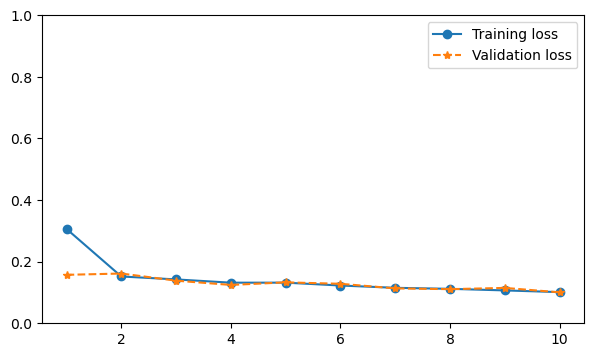

In [8]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
plt.ylim(0, 1)
ax.legend()
plt.show()

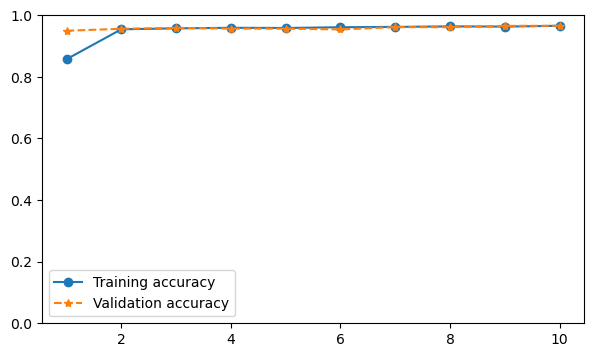

In [9]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
plt.ylim(0, 1)
ax.legend()
plt.show()

In [10]:
model.evaluate(test_data)

130/130 ━━━━━━━━━━━━━━━━━━━━ 130s 998ms/step - accuracy: 0.9594 - loss: 0.1081


[0.11103782802820206, 0.9632495045661926]

130/130 ━━━━━━━━━━━━━━━━━━━━ 129s 983ms/step
Confusion matrix:
 [[1972   96]
 [  56 2012]]


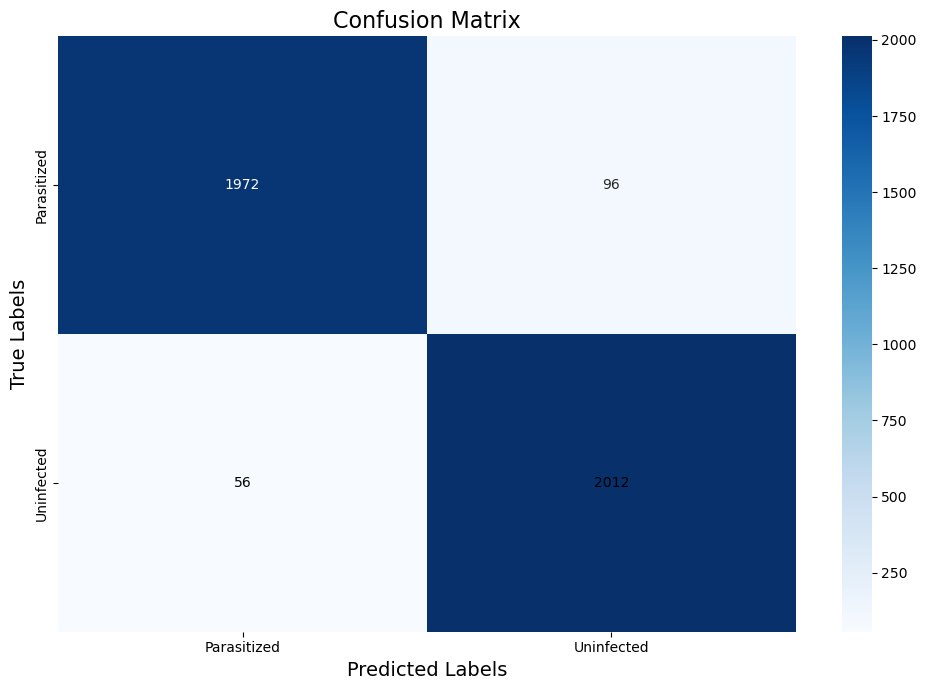

              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2068
  Uninfected       0.95      0.97      0.96      2068

    accuracy                           0.96      4136
   macro avg       0.96      0.96      0.96      4136
weighted avg       0.96      0.96      0.96      4136



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test data
predictions = model.predict(test_data)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Get true classes
true_classes = test_data.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print("Confusion matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)

for i, value in enumerate(conf_matrix[1]):
    plt.text(i + 0.5, 1.5, str(value), ha="center", va="center", color="black")

plt.xlabel('Predicted Labels', fontsize=14)  # Increase label font size for better visibility
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Ensure tight layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys()))